In [1]:
using PauliPropagation
using Random
using Optim
using Plots
using ReverseDiff: GradientTape, gradient!, compile, gradient
using LinearAlgebra
using StatsBase 
using GLM
using DataFrames
using CSV
using Format
using Logging

# CDR for quantum dynamics
- TFIM Hamiltonian (constants not site-dependent) evolving with TDSE
- discretize the evolution steps and use first-order Trotter decomposition 

### Idea:
- get plain CDR running for Dynamics and benchmark
- add perturbation approach (all non-Cliffords) if necessary
- add noise levels (data augmentation) if necessary



In [2]:
# some fancy log from ChatGPT
struct UnbufferedLogger <: Logging.AbstractLogger
    stream::IO
    level::Logging.LogLevel
end

const MainInfo = Base.CoreLogging.LogLevel(200)
const SubInfo = Base.CoreLogging.LogLevel(100)

const LOG_LEVEL_NAMES = Dict(
    Logging.Debug => "Debug",
    Logging.Info => "Info",
    Logging.Warn => "Warn",
    Logging.Error => "Error",
    SubInfo => "SubInfo",
    MainInfo => "MainInfo"
)

Logging.min_enabled_level(logger::UnbufferedLogger) = logger.level
Logging.shouldlog(logger::UnbufferedLogger, level, _module, group, id) = level ≥ logger.level
Logging.catch_exceptions(::UnbufferedLogger) = true

function Logging.handle_message(logger::UnbufferedLogger, level, message, _module, group, id, file, line; kwargs...)
    level_name = get(LOG_LEVEL_NAMES, level, "$level")  # Default for custom levels
    print(logger.stream, "[$level_name] ", message, "\n")  # Include log level
    flush(logger.stream)  # Ensure immediate output
end


global_logger(UnbufferedLogger(stdout, SubInfo))

Base.CoreLogging.SimpleLogger(VSCodeServer.IJuliaCore.IJuliaStdio{Base.PipeEndpoint, typeof(VSCodeServer.io_send_callback)}(IOContext(Base.PipeEndpoint(RawFD(29) open, 0 bytes waiting)), VSCodeServer.io_send_callback), Info, Dict{Any, Int64}())

In [3]:
# identic in both
struct trotter_ansatz_tfim
    target_circuit::Vector{Gate}
    target_circuit_layer::Vector{Gate}
    topology::Vector{Tuple{Int64, Int64}}
    nqubits::Integer
    steps::Integer #layers
    time::Float64
    J::Float64
    h::Float64
    sigma_J::Float64
    sigma_h::Float64
    sigma_J_indices::Vector{Int64}
    sigma_h_indices::Vector{Int64}
    sigma_J_indices_layer::Vector{Int64}
    sigma_h_indices_layer::Vector{Int64}
end

# took trotter version (trotter_ansatz_tfim instead of trotter_ansatz in the return)
function trotter_setup(nqubits::Integer, steps::Integer, time::Float64, J::Float64, h::Float64;topology = nothing)
    if isnothing(topology)
        topology = bricklayertopology(nqubits)
    end
    target_circuit = tfitrottercircuit(nqubits,steps,topology=topology) #start with RZZ layer
    target_circuit_layer = tfitrottercircuit(nqubits,1,topology=topology) #start with RZZ layer
    sigma_J = -2*T*J/steps
    sigma_h = 2*T*h/steps 

    sigma_J_indices = getparameterindices(target_circuit, PauliRotation, [:Z,:Z]) 
    sigma_h_indices = getparameterindices(target_circuit, PauliRotation, [:X])
    
    sigma_J_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:Z,:Z])
    sigma_h_indices_layer = getparameterindices(target_circuit_layer, PauliRotation, [:X])
    
    return trotter_ansatz_tfim(target_circuit,target_circuit_layer, topology, nqubits, steps, time, J, h,sigma_J, sigma_h,sigma_J_indices, sigma_h_indices, sigma_J_indices_layer, sigma_h_indices_layer)
end

trotter_setup (generic function with 1 method)

In [4]:
# trotter version improved
function constrain_params(ansatz; layer=false)
    """
    Set all RX gates and all RZZ gates to have the same parameter value respectively.
    """
    if layer
        nparams = countparameters(ansatz.target_circuit_layer)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices_layer] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices_layer] .= ansatz.sigma_J
    else
        nparams = countparameters(ansatz.target_circuit)
        thetas = zeros(nparams)
        thetas[ansatz.sigma_h_indices] .= ansatz.sigma_h
        thetas[ansatz.sigma_J_indices] .= ansatz.sigma_J
    end
    
    return thetas
end

constrain_params (generic function with 1 method)

In [5]:
# identic in both
function obs_magnetization(ansatz)
    """
    Returns the normalised magnetization.
    """
    magnetization = PauliSum(ansatz.nqubits)
    for i in 1:nq
        add!(magnetization,:Z,i)
    end
    magnetization = magnetization/nq
    return magnetization
end

obs_magnetization (generic function with 1 method)

In [6]:
# delete training_set_generation and keep training_set_generation_brut only, putting pi/4 as the angle definition by default (equivalent to training_set_generation)
function training_set_generation_brut(ansatz::trotter_ansatz_tfim, angle_definition::Float64=pi/4; num_samples::Int = 10, non_replaced_gates::Int = 30)
    """
    Generates a training set of thetas for the ansatz. The training set is generated by selecting a number of cliffords and non-cliffords
    and setting the corresponding thetas to multiples of angle_definition. 
    """
    nparams = countparameters(ansatz.target_circuit)
    replaced_gates = nparams - non_replaced_gates
    ratio = length(ansatz.sigma_J_indices)/(length(ansatz.sigma_h_indices)+length(ansatz.sigma_J_indices))
    num_h = Int(round((1-ratio)*replaced_gates))
    num_J = Int(round(ratio*replaced_gates))
    training_thetas_list = Vector{Vector{Float64}}()
    thetas = constrain_params(ansatz)
    for _ in 1:num_samples
        training_thetas = deepcopy(thetas)
        shuffled_sigma_h_indices =  Random.shuffle!(ansatz.sigma_h_indices)
        shuffled_sigma_J_indices = Random.shuffle!(ansatz.sigma_J_indices)
        selected_indices_h = shuffled_sigma_h_indices[1:num_h]
        selected_indices_J = shuffled_sigma_J_indices[1:num_J];   
        k_h =round(ansatz.sigma_h/(angle_definition))
        k_J =round(ansatz.sigma_J/(angle_definition))

        for i in selected_indices_h
            training_thetas[i] = k_h*angle_definition
        end
        for i in selected_indices_J
            training_thetas[i] = k_J*angle_definition
        end
        push!(training_thetas_list, training_thetas)
    end
    return training_thetas_list
end

training_set_generation_brut (generic function with 2 methods)

In [7]:
# called exact_trotter_time_evolution in trotter, merge for the record part otherwise trotter_perturbation
function trotter_time_evolution(ansatz; special_thetas=nothing, noise_kind="noiseless", record=false, min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01)
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if special_thetas==nothing
        thetas = constrain_params(ansatz)#,layer=record)
    else
        thetas = special_thetas
    end
    obs = obs_magnetization(ansatz)

    if noise_kind=="naive"
        if record
            error("Naive noise model doesn't support recording :(")
        else
            circuit = final_noise_layer_circuit(ansatz; depol_strength, dephase_strength)
        end
    elseif noise_kind=="gate"
        circuit = gate_noise_circuit(ansatz; depol_strength, dephase_strength, layer=record)
    elseif noise_kind=="noiseless"
        if record
            circuit = copy(ansatz.target_circuit_layer)
        else
            circuit = copy(ansatz.target_circuit)
        end
    else
        error("Noise kind $noise_kind unknown.")
    end

    if record
        nparams = countparameters(ansatz.target_circuit)
        expvals_trotter = Float64[]   
        push!(expvals_trotter, overlapwithzero(obs))
        for i in 1:ansatz.steps
            psum = propagate!(circuit, obs, thetas[Int(nparams/ansatz.steps*(i-1)+1):Int(nparams/ansatz.steps*i)])
            push!(expvals_trotter, overlapwithzero(psum))
        end
        return expvals_trotter  
    else 
        psum = propagate!(circuit, obs,  thetas)
        return overlapwithzero(psum)
    end
end

trotter_time_evolution (generic function with 1 method)

In [8]:
# exact_time_evolution in trotter, added recording to the trotter_perturbation version
function training_trotter_time_evolution(ansatz, training_thetas; noise_kind="noiseless", min_abs_coeff=0.0, depol_strength=0.01, dephase_strength=0.01, record=false)
    """
    Function that computes the time evolution of the ansatz using the first order Trotter approximation exact time evolution operator.
    The function returns the overlap of the final state with the |0> state.
    """
    if record 
        exact_expvals = Vector{Vector{Float64}}()
    else
        exact_expvals = Vector{Float64}()
    end
    for thetas in training_thetas
        push!(exact_expvals, trotter_time_evolution(ansatz; record=record, special_thetas=thetas, noise_kind=noise_kind, min_abs_coeff=min_abs_coeff, depol_strength=depol_strength, dephase_strength=dephase_strength))
    end
    return exact_expvals
end

training_trotter_time_evolution (generic function with 1 method)

In [9]:
# from trotter
function final_noise_layer_circuit(ansatz; depol_strength=0.05, dephase_strength=0.05)
    """
    Function that adds a final layer of depolarizing and dephasing noise to the ansatz.
    """
    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    dephase_noise_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];
    noisy_circuit = deepcopy(ansatz.target_circuit)
    append!(noisy_circuit,depol_noise_layer)
    append!(noisy_circuit,dephase_noise_layer)

    return noisy_circuit
end

# cleaned from trotter
function gate_noise_circuit(ansatz; depol_strength=0.01, dephase_strength=0.01, start_with_ZZ=true, layer=false)
    """
    Noise model from the CPA paper, where we add a layer of depolarizing and dephasing noise after each step/layer of the ansatz.
    """
    circuit::Vector{Gate} = []
    if layer
        steps = 1
    else
        steps = ansatz.steps
    end

    # the function after this expects a circuit with at least one layer and will always append something
    if steps<1
        error("The number of steps should be at least 1 (steps=$steps).")
    end

    depol_noise_layer = [DepolarizingNoise(qind, depol_strength ) for qind in 1:ansatz.nqubits];
    phase_damp_layer = [DephasingNoise(qind, dephase_strength) for qind in 1:ansatz.nqubits];

    if start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    for _ in 1:steps-1
        rxlayer!(circuit, ansatz.nqubits)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    rxlayer!(circuit, ansatz.nqubits)
    append!(circuit, depol_noise_layer)
    append!(circuit, phase_damp_layer)

    if !start_with_ZZ
        rzzlayer!(circuit, ansatz.topology)
        append!(circuit, depol_noise_layer)
        append!(circuit, phase_damp_layer)
    end

    return circuit
end

gate_noise_circuit (generic function with 1 method)

In [10]:
# from trotter_perturbation
function cdr(noisy_exp_values::Vector{Float64}, exact_exp_values::Vector{Float64}, noisy_target_exp_value::Float64, exact_target_exp_value::Float64)
    training_data = DataFrame(x=noisy_exp_values,y=exact_exp_values)
    ols = lm(@formula(y ~ x), training_data)
    function cdr_em(x)
        return  coef(ols)[1] + coef(ols)[2] * x
    end
    rel_error_after = abs(exact_target_exp_value - cdr_em(noisy_target_exp_value)) / abs(exact_target_exp_value)
    rel_error_before = abs(exact_target_exp_value - noisy_target_exp_value) / abs(exact_target_exp_value)
    # if verbose
    #     println(training_data)
    #     println("Noisy target expectation value: ", noisy_target_exp_value)
    #     println("Relative error before CDR: ", rel_error_before)
    #     println("CDR-EM target expectation value: ", cdr_em(noisy_target_exp_value))
    #     println("Relative error after CDR: ", rel_error_after)
    # end
    @debug training_data
    @logmsg SubInfo "Noisy target expectation value: $(noisy_target_exp_value)"
    @logmsg SubInfo "Relative error before CDR: $(rel_error_before)"
    @logmsg SubInfo "CDR-EM target expectation value: $(cdr_em(noisy_target_exp_value))"
    @logmsg SubInfo "Relative error after CDR: $(rel_error_after)"
    return cdr_em(noisy_target_exp_value), rel_error_after, rel_error_before
end 

cdr (generic function with 1 method)

In [11]:
# from trotter_perturbation
function full_run(ansatz, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy; num_samples=10, non_replaced_gates=30)
    @logmsg SubInfo "ready to ruuuuuummmble"

    time1 = time()
    exact_expval_target = trotter_time_evolution(ansatz; noise_kind="noiseless") #should be close to one as we stay in FM phase
    timetmp1 = time()
    @logmsg SubInfo "exact_expval_target done in $(round(timetmp1-time1; digits = 2)) s"

    noisy_expval_target = trotter_time_evolution(ansatz; noise_kind=noise_kind)
    timetmp2 = time()
    @logmsg SubInfo "noisy_expval_target done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    angle_definition = pi/8
    training_set = training_set_generation_brut(ansatz, angle_definition; num_samples=num_samples, non_replaced_gates=non_replaced_gates); 
    timetmp2 = time()
    @logmsg SubInfo "training_set_generation_brut done in $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    
    exact_expvals = training_trotter_time_evolution(ansatz, training_set; noise_kind="noiseless", min_abs_coeff=min_abs_coeff_noisy);
    timetmp2 = time()
    @logmsg SubInfo "training_exact_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    noisy_expvals = training_trotter_time_evolution(ansatz, training_set; noise_kind=noise_kind, min_abs_coeff=min_abs_coeff_noisy);
    timetmp2 = time()
    @logmsg SubInfo "noisy_time_evolution_brut done in  $(round(timetmp2-timetmp1; digits = 2)) s"
    timetmp1 = timetmp2
    
    corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals, exact_expvals, noisy_expval_target[1], exact_expval_target)  
    timetmp2 = time()
    @logmsg SubInfo "cdr done in  $(round(timetmp2-timetmp1; digits=2)) s"

    @logmsg MainInfo "nq=$(ansatz.nqubits) noise=$noise_kind total run done in $(round(timetmp2-time1; digits=2)) s"

    # open file in append mode 
    if noise_kind=="naive"
        log = open("trotter_brut_naive.log", "a")  
    elseif noise_kind=="gate"
        log = open("trotter_brut_gate.log", "a")
    else
        error("Noise kind $noise_kind unknown.")
    end
    str = format("{:>5n} {:>5n} {:>6.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e} {:>10.2e}\n", nq, steps, T, J, h, angle_definition, min_abs_coeff, min_abs_coeff_noisy, exact_expval_target, noisy_expval_target[1], rel_error_before, rel_error_after, timetmp2-time1);
    # writing to a file using write() method  
    write(log, str)  
        
    # We need to close the file in order to write the content from the disk to file  
    close(log)
    return exact_expval_target, noisy_expval_target[1], corr_energy, rel_error_before, rel_error_after
end

full_run (generic function with 1 method)

# MWE
### Exact evolution of a small trotterized circuit (see CPDR p.7)

In [12]:
nq = 4
steps = 40
T = 2.0
J =  5.0 # J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase

#paramagnetic (h = -2, J =1)
trotter = trotter_setup(nq, steps, T, J, h);
noisy_circuit = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);
noisy_circuit_layer = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01, layer = true);

### Target data

In [13]:
exact_expval_target = trotter_time_evolution(trotter; record=true); #should be close to one as we stay in FM phase

In [14]:
noisy_expval_target = trotter_time_evolution(trotter; noise_kind="gate", record=true);

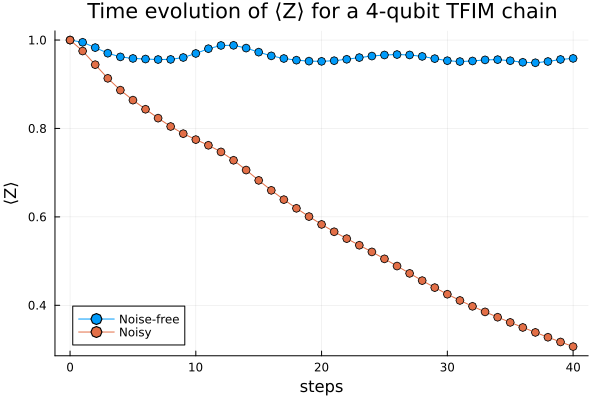

In [15]:
plot(0:trotter.steps,exact_expval_target,
 ylabel="⟨Z⟩", xlabel="steps", label="Noise-free", marker=:o)
plot!(0:trotter.steps, noisy_expval_target, label="Noisy", marker=:o, c=2)
plot!(title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

### Training data

In [16]:
list_training_thetas = training_set_generation_brut(trotter; num_samples=10, non_replaced_gates=30)

10-element Vector{Vector{Float64}}:
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.1, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.1, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.0, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.5, -0.5, -0.5, 0.1, 0.0, 0.1, 0.0]
 [-0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.1, 0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483  …  0.0, 0.0, 0.0, -0.7853981633974483, -0.7853981633974483, -0.7853981633974483, 0.1, 0.0, 0.1, 0.0]
 [-0.78539816

In [17]:
exact_expvals = training_trotter_time_evolution(trotter, list_training_thetas; record=true);
#problem: in the record, we need to take the new corresponding thetas of each layer.

10-element Vector{Vector{Float64}}:
 [1.0, 1.0, 1.0, 0.9987510413195064, 0.9987510413195064, 0.9975020826390129, 0.9975020826390129, 0.9962531239585194, 0.9962531239585194, 0.9973893488675687  …  0.9896175043695183, 0.9893831362718952, 0.9893831362718952, 0.9833323193490607, 0.9833323193490607, 0.9833323193490607, 0.9833323193490607, 0.9833323193490607, 0.9833323193490607, 0.9841921820259858]
 [1.0, 1.0, 1.0, 0.9987510413195064, 0.9987510413195064, 0.9987510413195064, 0.9969608693407425, 0.995704186114907, 0.995704186114907, 0.995704186114907  …  0.9877659850270983, 0.9877659850270983, 0.9871669717247119, 0.9871669717247119, 0.9871669717247119, 0.9871669717247119, 0.9871669717247119, 0.9871669717247119, 0.9871669717247119, 0.9815644412310571]
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9987510413195064, 0.9987510413195064  …  0.9880626047668354, 0.9880626047668354, 0.9880626047668354, 0.9880626047668354, 0.9846313444778507, 0.98723690831112, 0.98723690831112, 0.98723690831112, 0.987236

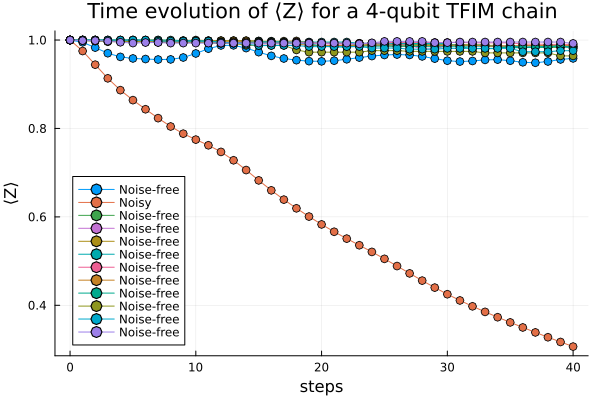

In [18]:
for i in exact_expvals
    plot!(0:trotter.steps,i, label="Noise-free", marker=:o)
end
plot!(xlabel = "steps", ylabel="⟨Z⟩", title = "Time evolution of ⟨Z⟩ for a 4-qubit TFIM chain")

In [19]:
noisy_expvals = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="gate", record = true);

In [20]:
println(noisy_expvals)

[[1.0, 0.9801, 0.96059601, 0.9403042795958931, 0.9215922244319348, 0.9021230033226744, 0.884170755556553, 0.8654907298969774, 0.8482674643720276, 0.8318782072962793, 0.8152646147726249, 0.799452190136326, 0.7834339107683872, 0.7677407844030515, 0.7517272398434393, 0.7366201737847504, 0.7199708040159238, 0.7054118356677623, 0.6911561410229949, 0.6771968919772975, 0.6626725462954611, 0.6493041877509202, 0.6355274479199756, 0.6206532913688875, 0.6080920654318537, 0.5961844317227716, 0.5841340918429956, 0.5723344542011688, 0.5607798919286261, 0.5493066348178677, 0.5381712400759259, 0.5272693890161767, 0.5162904110619204, 0.505846534384852, 0.4932988550552522, 0.4833333311927325, 0.47357483349421226, 0.4640187323000955, 0.4546605199167101, 0.44549580644320563, 0.43652208201976445], [1.0, 0.9801, 0.96059601, 0.9403042795958931, 0.9215922244319348, 0.9032525391657393, 0.8836102762182583, 0.8648900384627565, 0.8476358326046398, 0.8307274955989965, 0.8139173072102255, 0.796528456717546, 0.78064

In [21]:
noisy_circ = gate_noise_circuit(trotter, depol_strength = 0.01, dephase_strength = 0.01);

In [22]:
exact_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; record=false);
noisy_expvals_cdr = training_trotter_time_evolution(trotter, list_training_thetas; noise_kind="gate", record = false);
corr_energy, rel_error_after, rel_error_before = cdr(noisy_expvals_cdr, exact_expvals_cdr, noisy_expval_target[end], exact_expval_target[end])  

[SubInfo] Noisy target expectation value: 0.3065011062578489
[SubInfo] Relative error before CDR: 0.6802314164737944
[SubInfo] CDR-EM target expectation value: 0.6989771733325345
[SubInfo] Relative error after CDR: 0.2707662841332013


(0.6989771733325345, 0.2707662841332013, 0.6802314164737944)

## Trying to make CDR work

In [23]:
# Set the unbuffered logger globally
global_logger(UnbufferedLogger(stdout, SubInfo))


nq = 8
steps = 10
angle_definition = pi/8
T = 1.
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
# J = 1.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
# h = -2.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nq, steps, T, J, h);

noise_kind = "gate"
min_abs_coeff = 1e-10;
min_abs_coeff_noisy = min_abs_coeff;

# with_logger(infologger) do
#     full_run(nq, steps, angle_definition, T, J, h, trotter, noise_kind, min_abs_coeff, min_abs_coeff_noisy)
# end
full_run(trotter, angle_definition, noise_kind, min_abs_coeff, min_abs_coeff_noisy)


[SubInfo] ready to ruuuuuummmble
[SubInfo] exact_expval_target done in 0.55 s
[SubInfo] noisy_expval_target done in 0.29 s
[SubInfo] training_set_generation_brut done in 0.0 s
[SubInfo] training_exact_time_evolution_brut done in  1.6 s
[SubInfo] noisy_time_evolution_brut done in  3.51 s
[SubInfo] Noisy target expectation value: 0.7295983642404753
[SubInfo] Relative error before CDR: 0.2383089684410634
[SubInfo] CDR-EM target expectation value: 1.0555744294600713
[SubInfo] Relative error after CDR: 0.1020057273561437
[SubInfo] cdr done in  0.0 s
[MainInfo] nq=8 noise=gate total run done in 5.95 s


(0.9578665548250215, 0.7295983642404753, 1.0555744294600713, 0.2383089684410634, 0.1020057273561437)

In [24]:
global_logger(UnbufferedLogger(stdout, MainInfo))

nqubits = 4
steps = 10
angle_definition = pi/4
T = 1.0
J = 5.0 #J > 0 in ferromagnetic phase, J < 0 in antiferromagnetic phase
h = 1.0 #abs(h) < abs(J) in ordered phase
trotter = trotter_setup(nqubits, steps, T, J, h);
nsamples = 10:10:100

noise_kind = "gate"
min_abs_coeff = 1e-6;
min_abs_coeff_noisy = min_abs_coeff;


rel_err_ratio_gate = []

for nsample=nsamples
    exact_expvals, noisy_expvals, corr_energy, rel_error_before, rel_error_after = full_run(trotter, angle_definition, "gate", min_abs_coeff, min_abs_coeff_noisy; num_samples=nsample)
    push!(rel_err_ratio_gate, rel_error_before/rel_error_after)
end



[MainInfo] nq=4 noise=gate total run done in 0.01 s
[MainInfo] nq=4 noise=gate total run done in 0.03 s
[MainInfo] nq=4 noise=gate total run done in 0.04 s
[MainInfo] nq=4 noise=gate total run done in 0.05 s
[MainInfo] nq=4 noise=gate total run done in 0.07 s
[MainInfo] nq=4 noise=gate total run done in 0.08 s
[MainInfo] nq=4 noise=gate total run done in 0.09 s
[MainInfo] nq=4 noise=gate total run done in 0.11 s
[MainInfo] nq=4 noise=gate total run done in 0.12 s
[MainInfo] nq=4 noise=gate total run done in 0.15 s


In [25]:
df = DataFrame(nqubits = nqubits, rel_err_ratio_gate = rel_err_ratio_gate)
fn = format("data/J={:.2f}_h={:.2f}_T={:.2f}_angdef={:.2f}_steps={:n}_nqubits={:n}_nsamples_{:n}_to_{:n}_minabs={:.2e}_minabsnoisy={:.2e}.csv", J, h, T, angle_definition, steps, nqubits, nsamples[1], nsamples[end], min_abs_coeff, min_abs_coeff_noisy)
CSV.write(fn, df)

"data/J=5.00_h=1.00_T=1.00_angdef=0.79_steps=10_nqubits=4_nsamples_10_to_100_minabs=1.00e-06_minabsnoisy=1.00e-06.csv"

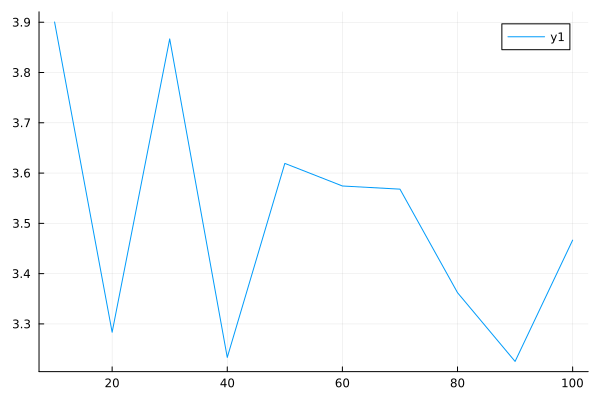

In [26]:
plot(nsamples, rel_err_ratio_gate)
